In [1]:
import datetime
import pandas as pd
import numpy as np
import empyrical
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
FUNDS = ['070037.OF', '160706.OF', '000008.OF', '000071.OF', '050025.OF']

In [3]:
risk_free = 0.015 # 1年期定期存款利率
DIR = u'\\\\hfm-pubshare\HFM各部门共享\Harvest嘉实全体员工\策略孵化组\多重风管分组审核\zhangyang\江苏银行全球购策略'
WEIGHT_FILE = u'%s\产品历史占比.xlsx'%(DIR)
DAILY_DATA_FILE = u'%s/行情数据.xlsx'%(DIR)

In [4]:
wdf = pd.read_excel(WEIGHT_FILE, skiprows=1, index_col=0, sheet_name='Sheet4')
fdf = pd.read_excel(DAILY_DATA_FILE, sheet_name=u'基金')
sdf = pd.read_excel(DAILY_DATA_FILE, sheet_name=u'基准')

# 确定起始日期

In [5]:
start_date = '2016-11-17'
today = datetime.datetime.today()
this_friday = today - datetime.timedelta((today.weekday() - 4 + 7) % 7)
last_friday = this_friday - datetime.timedelta(7)
end_date = this_friday
print(this_friday, last_friday)

2019-11-22 11:19:33.677476 2019-11-15 11:19:33.677476


# 获取历史数据

In [6]:
wdf = wdf[wdf.index >= start_date]

In [7]:
df = fdf[(fdf.index >= start_date) & (fdf.index <= end_date)]

In [8]:
df.tail()

,070037.OF,160706.OF,000008.OF,000071.OF,050025.OF
2019-11-18,1.156,1.1343,1.3266,1.4894,2.4690
2019-11-19,1.156,1.1451,1.3478,1.5110,2.4674
2019-11-20,1.156,1.1344,1.3405,1.5014,2.4619
2019-11-21,1.157,1.1293,1.3401,1.4819,2.4616
2019-11-22,1.157,1.1183,1.3293,1.4912,2.4694


In [9]:
rdf = df.pct_change()

In [10]:
wdf.columns = rdf.columns

In [11]:
wdf.head()

,070037.OF,160706.OF,000008.OF,000071.OF,050025.OF
2016-11-17,0.1,0.0,0.0,0.225,0.675
2016-11-18,0.1,0.0,0.0,0.225,0.675
2016-11-21,0.1,0.0,0.0,0.225,0.675
2016-11-22,0.1,0.0,0.0,0.225,0.675
2016-11-23,0.1,0.0,0.0,0.225,0.675


In [12]:
rdf.head()

,070037.OF,160706.OF,000008.OF,000071.OF,050025.OF
2016-11-17,NaN,NaN,NaN,NaN,NaN
2016-11-18,-0.000842,-0.005116,-0.004526,0.004504,-0.000702
2016-11-21,0.000000,0.006479,0.001347,0.002740,0.009539
2016-11-22,0.000000,0.007562,0.007118,0.011013,-0.000638
2016-11-23,0.000843,0.001724,-0.004007,0.000819,0.002494


In [13]:
if rdf.shape[0] > wdf.shape[0]: # 补充完整
    print('Append')
    app_df = pd.DataFrame(np.nan, columns=wdf.columns, index=rdf[rdf.index > wdf.index[-1]].index)
    wdf = wdf.append(app_df)
    wdf = wdf.fillna(method='ffill')
elif rdf.shape[0] < wdf.shape[0]:
    print('Cut')
    wdf = wdf.loc[rdf.index]

Append


In [14]:
assert(rdf.shape == wdf.shape)

# 计算组合和基准收益率

In [15]:
portfolio_ret = (wdf * rdf).sum(axis=1)

In [16]:
bench = sdf[(sdf.index >= start_date) & (sdf.index <= end_date)]

In [17]:
bench = bench.pct_change().fillna(0)

In [18]:
bench_ret = bench.mul(np.array([0.3, 0.3, 0.3, 0.1])).sum(axis=1)

In [19]:
import matplotlib
matplotlib.matplotlib_fname() #将会获得matplotlib包所在文件夹

'C:\\Users\\zhangyang01\\AppData\\Local\\Programs\\Python\\Python36-32\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc'

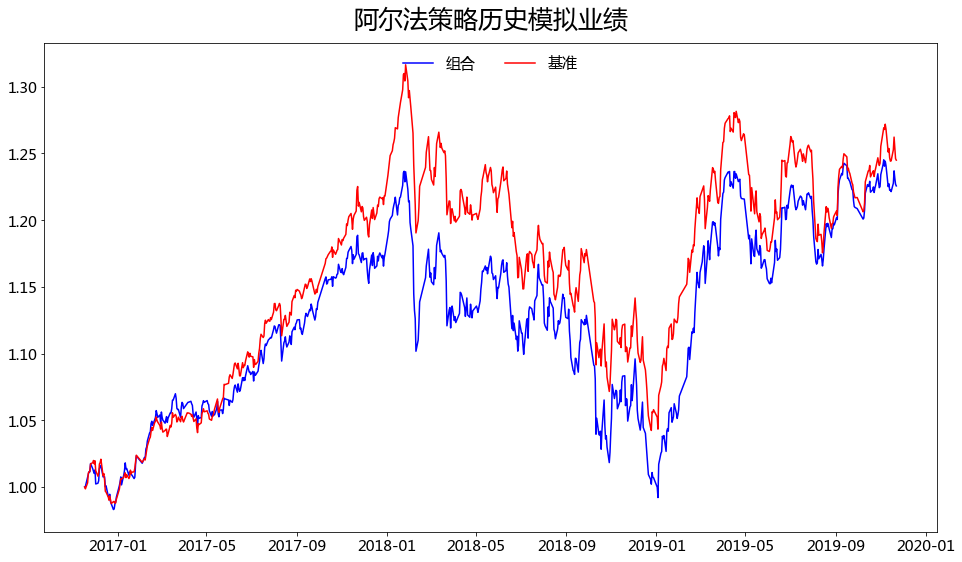

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio_ret).cumprod(), color='blue', label=u'组合')
lns2 = ax.plot((1 + bench_ret).cumprod(), color='red', label=u'基准')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.2f}'.format(x) for x in vals])

_ = ax.set_title(u'阿尔法策略历史模拟业绩', fontsize=25, y=1.02)

### 计算净值

In [21]:
nav = (1 + portfolio_ret).cumprod()

# 输出结果到Excel Sheet

In [22]:
results = pd.DataFrame(columns=[u'一键买全球'], 
                       index=[u'上周净值', u'本周净值', u'本周基准收益率', u'本周收益率', u'本周超额收益', \
                              u'年化收益率', u'年化波动率', u'最大回撤', u'夏普比率'])
results.index.name = u'指标'

In [23]:
results.loc[u'上周净值'] = '{:2.4f}'.format(nav[nav.index <= last_friday][-1])

In [24]:
results.loc[u'本周净值'] = '{:2.4f}'.format(nav[nav.index <= this_friday][-1])

In [25]:
b_ret = empyrical.cum_returns_final(bench_ret[(bench_ret.index > last_friday) & (bench_ret.index <= this_friday)])
results.loc[u'本周基准收益率'] = '{:2.4f}%'.format(b_ret*100)

In [26]:
p_ret = empyrical.cum_returns_final(portfolio_ret[(portfolio_ret.index > last_friday) & (portfolio_ret.index <= this_friday)])
results.loc[u'本周收益率'] = '{:2.4f}%'.format(p_ret*100)

In [27]:
results.loc[u'本周超额收益'] = '{:2.4f}%'.format((p_ret - b_ret)*100)

In [28]:
results.loc[u'年化收益率'] = '{:2.2f}%'.format(empyrical.annual_return(portfolio_ret)*100)

In [29]:
results.loc[u'年化波动率'] = '{:2.2f}%'.format(empyrical.annual_volatility(portfolio_ret)*100)

In [30]:
results.loc[u'最大回撤'] = '{:2.2f}%'.format(empyrical.max_drawdown(portfolio_ret)*100)

In [31]:
results.loc[u'夏普比率'] = '{:2.2f}'.format(empyrical.sharpe_ratio(portfolio_ret))

In [32]:
results

,一键买全球
指标,
上周净值,1.2214
本周净值,1.2257
本周基准收益率,0.0448%
本周收益率,0.3502%
本周超额收益,0.3054%
年化收益率,7.22%
年化波动率,11.60%
最大回撤,-19.78%
夏普比率,0.66


In [33]:
DIR = u'\\\\hfm-pubshare\HFM各部门共享\Harvest嘉实全体员工\策略孵化组\多重风管分组审核\zhangyang\江苏银行全球购策略\周度业绩回顾'
fname = u'%s\一键买全球周度业绩回顾-%s.xlsx'%(DIR, today.strftime('%Y-%m-%d'))

In [34]:
results.to_excel(fname)

In [35]:
fname = u'%s\一键买全球周度业绩回顾.xlsx'%(DIR)

In [36]:
results.to_excel(fname)